# Optimization of Nonlocality against CHSH Inequality

This notebook considers the bipartite, nonsignaling CHSH scenario.

<div>
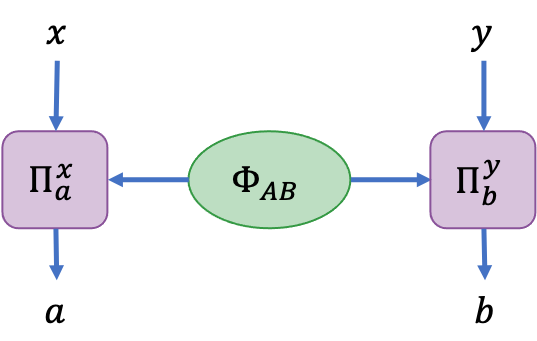
</div>
    
<!-- <img src="images/chsh_scenario.png" alt="chsh scenario" width="200"/> -->

Here $x$, $y$, $a$, and $b$ are all classical, binary values.
In this scenario, quantum probabilities are constructed as $P(ab|xy) = \text{Tr}[\Pi_a^x\otimes\Pi_b^y\Phi_{AB}]$ and expectation values for a particular observable are defined as
$\langle A_xB_y\rangle = \sum_{a,b\in\{0,1\}} (-1)^{a+b}P(ab|xy)$.
The CHSH inequality is then

$$
\langle A_0B_0\rangle + \langle A_0 B_1\rangle \langle A_1 B_0 \rangle - \langle A_1 B_1 \rangle \leq 2.
$$

For quantum systems, the left hand side can be as large as $2\sqrt{2}$.

### Goal: Find a set of states and measurements that optimally violate the CHSH inequality.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

### Setup the Quantum Circuits

In [2]:
# The CHSH scenario only requires two qubits ("a" and "b") to simulate
dev = qml.device("default.qubit", wires=["a", "b"])

# optimizer
opt = qml.GradientDescentOptimizer()

@qml.qnode(dev)
def real_chsh_circuit(a_state, b_state, a_measurement, b_measurement):  
    """
    Ansatz circuit where states and measurents are free to rotate about the y-axis.
    In this model, all quantum states real.

    Args:
        a_state (float) : local rotation angle on Alice's state
        b_state (float) : local rotation angle on Bob's state
        a_measurement (float) : rotation angle of Alice's measurement
        b_measurement (float) : rotation angle of Bob's measurement
    """
    qml.Hadamard(wires="a")
    qml.CNOT(wires=["a", "b"])
    
    qml.RY(a_state, wires="a")
    qml.RY(b_state, wires="b")
    
    qml.RY(a_measurement, wires="a")
    qml.RY(b_measurement, wires="b")
    return qml.expval(qml.PauliZ("a") @ qml.PauliZ("b"))

@qml.qnode(dev)
def arbitrary_chsh_circuit(state_settings, measurement_a_settings, measurement_b_settings):
    """
    Ansatz circuit where states are prepared with a two-qubit `ArbitraryUnitary` gate and
    measurements are prepared with a one-qubit `ArbitraryUnitary` gate.

    Args:
        state_settings (list[float]) : 15 angle parameters for the arbitrary two-qubit state.
        measurement_a_settings (list[float]) : 3 angle parameters for Alice's local measurement.
        measurement_b_settings (list[float]) : 3 angle parameters for Bob's local measurement.
    """
    qml.templates.subroutines.ArbitraryUnitary(state_settings, ["a","b"])
    
    qml.templates.subroutines.ArbitraryUnitary(measurement_a_settings, ["a"])
    qml.templates.subroutines.ArbitraryUnitary(measurement_b_settings, ["b"])
    return qml.expval(qml.PauliZ("a") @ qml.PauliZ("b"))

### Setup methods to randomize initial conditions

In [3]:
def real_chsh_rand_settings():
    """
    Returns a (3,2) tensor containing random values for the input to `real_chsh_circuit()`.
    """
    return 2*np.pi*np.random.random((3, 2)) - np.pi

def arbitrary_chsh_rand_settings():
    """
    Returns a 27-element list containing random values for the input to `arbitrary_chsh_circuit()`.
    """
    return 2*np.pi*np.random.random(27) - np.pi

### Setup the Cost Function

In [4]:
def real_chsh_cost(real_settings):
    """
    Applies the CHSH inequality as a cost function with respect to the `real_chsh_circuit()`.
    """
    run1 = real_chsh_circuit(real_settings[0,0], real_settings[0,1], real_settings[1, 0], real_settings[2, 0])
    run2 = real_chsh_circuit(real_settings[0,0], real_settings[0,1], real_settings[1, 0], real_settings[2, 1])
    run3 = real_chsh_circuit(real_settings[0,0], real_settings[0,1], real_settings[1, 1], real_settings[2, 0])
    run4 = real_chsh_circuit(real_settings[0,0], real_settings[0,1], real_settings[1, 1], real_settings[2, 1])
    return -(run1 + run2 + run3 - run4)
    
def arbitrary_chsh_cost(arb_settings):
    """
    Applies the CHSH inequality as a cost function with respect to the `arbitrary_chsh_circuit()`.
    """
    run1 = arbitrary_chsh_circuit(arb_settings[0:15], arb_settings[15:18], arb_settings[21:24])
    run2 = arbitrary_chsh_circuit(arb_settings[0:15], arb_settings[15:18], arb_settings[24:27])
    run3 = arbitrary_chsh_circuit(arb_settings[0:15], arb_settings[18:21], arb_settings[21:24])
    run4 = arbitrary_chsh_circuit(arb_settings[0:15], arb_settings[18:21], arb_settings[24:27])
    return -(run1 + run2 + run3 - run4)

### Optimizing the CHSH circuit over the real parameter space

In [5]:
# initial settings
real_settings = real_chsh_rand_settings()
real_scores = []

# performing gradient descent
for i in range(500):
    real_settings = opt.step(real_chsh_cost, real_settings)
    score = -(real_chsh_cost(real_settings))
    real_scores.append(score)
    
    if i%50 == 0:
        print("iteration : ",i, ", score : ", score)
        print("settings :\n", real_settings, "\n")

# printing final results    
print("final score : ", score,",")
print("final settings : ", real_settings)

iteration :  0 , score :  1.9723430799740578
settings :
 [[-0.17636146 -1.35831653]
 [ 2.94099102  2.82410772]
 [-1.99635734  0.70812706]] 

iteration :  50 , score :  2.1894087187381035
settings :
 [[-0.05594116 -1.47873683]
 [ 3.14954841  2.73597063]
 [-2.00825091  0.59960033]] 

iteration :  100 , score :  2.482067703814696
settings :
 [[ 0.01940792 -1.55408591]
 [ 3.38342472  2.5774434 ]
 [-1.88530136  0.40130169]] 

iteration :  150 , score :  2.71154293385578
settings :
 [[ 0.06544593 -1.60012392]
 [ 3.57685797  2.43004816]
 [-1.75134417  0.2213065 ]] 

iteration :  200 , score :  2.7974071977777095
settings :
 [[ 0.08118603 -1.61586402]
 [ 3.68896682  2.33367941]
 [-1.66074724  0.11496947]] 

iteration :  250 , score :  2.820774877567115
settings :
 [[ 0.08534486 -1.62002285]
 [ 3.74546197  2.28134309]
 [-1.61112454  0.06118794]] 

iteration :  300 , score :  2.8265743209964342
settings :
 [[ 0.08636822 -1.62104621]
 [ 3.77308796  2.25474046]
 [-1.58583852  0.03487855]] 

iterat

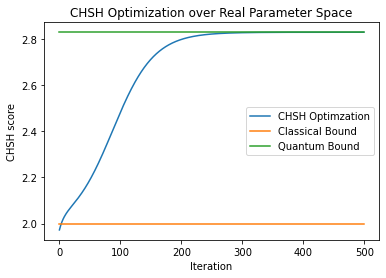

In [6]:
# Plot the individual observables
plt.plot(range(500), real_scores , label = "CHSH Optimzation")
plt.plot(range(500), [2]*500, label = "Classical Bound")
plt.plot(range(500), [2*np.sqrt(2)]*500, label = "Quantum Bound")
plt.title("CHSH Optimization over Real Parameter Space")
plt.xlabel("Iteration")
plt.ylabel("CHSH score")
plt.legend()
plt.show()

### Optimizing the CHSH circuit over general parameter space

In [7]:
# optimizing arbitrary unitary circuit
arbitrary_settings = arbitrary_chsh_rand_settings()
arb_scores = []

# performing gradient descent
for i in range(500):
    arbitrary_settings = opt.step(arbitrary_chsh_cost, arbitrary_settings)
    score = -(arbitrary_chsh_cost(arbitrary_settings))
    arb_scores.append(score)
    
    if i%50 == 0:
        print("iteration : ",i, ", score : ", score)
        print("settings :\n", arbitrary_settings, "\n")

# printing final results    
print("final score : ", score,",")
print("final settings : ", arbitrary_settings)

iteration :  0 , score :  0.06772569426838593
settings :
 [-0.56730099 -1.9969323   0.17413592 -1.11732567 -1.74330233  0.01127433
 -1.83025117  0.80454635 -0.66694076 -1.99237303 -1.60047485  1.5658302
  1.54240623  0.96597055  0.19086436  2.2484738   2.15129806  2.74980751
  1.38494978  1.17800963  1.44017469 -1.52790173 -0.46972026  1.60016891
 -0.09469561  2.30177757  1.99225746] 

iteration :  50 , score :  2.559838890374355
settings :
 [-7.36271920e-01 -1.73451475e+00  7.05455292e-02 -1.22402871e+00
 -1.79285459e+00  3.89396101e-01 -1.88293905e+00  8.45757215e-01
 -9.10414265e-01 -2.20870283e+00 -1.39154616e+00  1.25846759e+00
  1.65281431e+00  1.08398380e+00  1.13430274e-01  2.25649295e+00
  2.17054278e+00  2.74980751e+00  1.14383290e+00  7.34982974e-01
  1.44017469e+00 -1.94185539e+00 -3.74489115e-01  1.60016891e+00
  1.68640967e-04  2.05065914e+00  1.99225746e+00] 

iteration :  100 , score :  2.7823883183193754
settings :
 [-0.71922105 -1.73986473  0.08660438 -1.20514117 -1.8

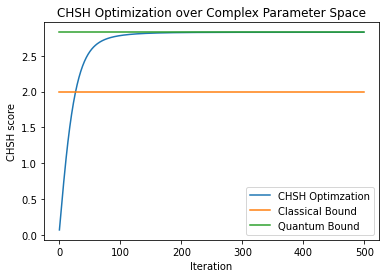

In [8]:
# Plot the individual observables
plt.plot(range(500), arb_scores , label = "CHSH Optimzation")
plt.plot(range(500), [2]*500, label = "Classical Bound")
plt.plot(range(500), [2*np.sqrt(2)]*500, label = "Quantum Bound")
plt.title("CHSH Optimization over Complex Parameter Space")
plt.xlabel("Iteration")
plt.ylabel("CHSH score")
plt.legend()
plt.show()